# Colates, cleans and analyses canopy temperature data from Rain shelter wheat trail

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline
import matplotlib.dates as mdates
import GraphHelpers as GH

In [4]:
Data = pd.read_pickle('.\DataFrames\TempAndRadnCleaned.pkl')
#Data.columns = Data.columns.droplevel(level=[3,4,5,6])
Data.sort_index(axis=1, inplace = True)
Data.sort_index(inplace = True)

#Add surface temperature difference (TsTa) into DataFrame
Data = Data.join(pd.concat([np.subtract(Data.loc[:,'IR_SurfaceTemp'], Data.loc[:,'AirTemperature'].values)], #Subtract Ts from Ta to get the differeince
          axis=1,keys=['TsTa'],names=['Measurement']),sort=True) # Join a descriptor level into the index

Ic = 0.8
Icl = 0.9
Cp = 1013 #Heat capacity of air Joule/kg/oC
Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28

In [6]:
GPs = GH.SetGraphicsPatterns(Data.IR_SurfaceTemp.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','orange','green'])

Start = Data.index.min()
End = Data.index.max()

Species
['Lucerne', 'Ryegrass']
Irrigation
['Dry', 'High', 'Low', 'Mid']
Treatments
MultiIndex(levels=[['Lucerne', 'Ryegrass'], ['Dry', 'High', 'Low', 'Mid']],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 2, 3, 0, 1, 2, 3]])
Styles
[('-', 'red', 0.15, 'o'), ('-', 'blue', 0.15, 'o'), ('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('--', 'red', 0.45, '^'), ('--', 'blue', 0.45, '^'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Lucerne  Dry    -     red  0.15   o     red
         High   -    blue  0.15   o    blue
         Low    -  orange  0.15   o  orange
         Mid    -   green  0.15   o   green
Ryegrass Dry   --     red  0.45   ^   white
         High  --    blue  0.45   ^   white
         Low   --  orange  0.45   ^   white
         Mid   --   green  0.45   ^   white


## Look at treatment patterns of surface temp differential

In [7]:
Start = '2013-02-01'
End = '2013-02-8'

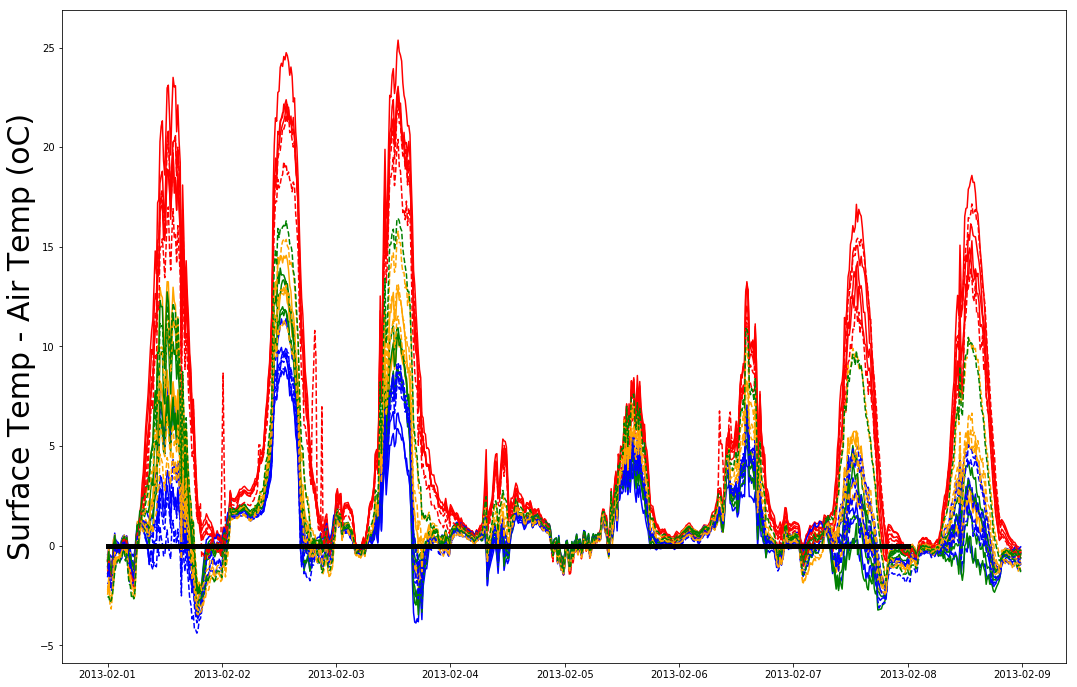

In [8]:
Figure = plt.figure(figsize=(18, 12))
ax = Figure.add_subplot(1,1,1)
GH.AddIndexedPlot(Data.TsTa.loc[Start:End],ax,GPs,1.5)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.plot(pd.to_datetime([Start,End]),[0,0], c='k', linewidth=5)

### The temperature differences are comming mostly during the day time but they are non zero at night and some treatment differences remain so will will remove the night time data from our daily means

## Set up a mask for day-light hours and filter out all data after dark

### First look at the radiation data

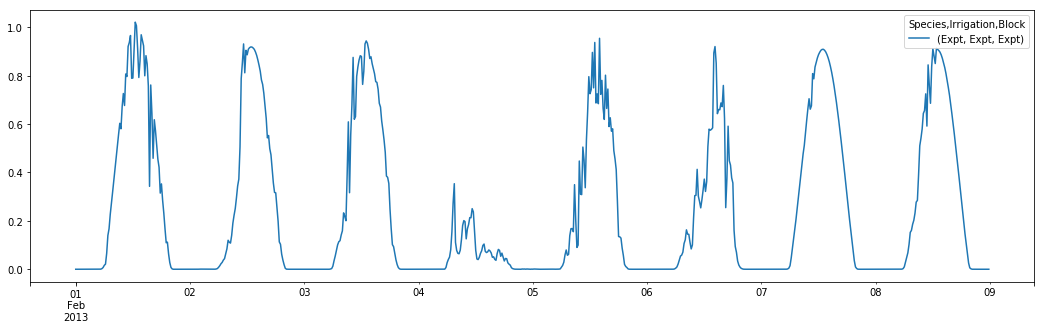

In [9]:
Data.IncomingRadnMJ.loc[Start:End].plot(figsize=(18,5))

### Values less that 0.002 MJ/h can be treated as dark

### Create a tuple of the time stamps that have radiation > 0.002 MJ/h

In [10]:
DaylightIndex = Data.IncomingRadnMJ.where(Data.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()

### Create temperature dataframes with daylight data

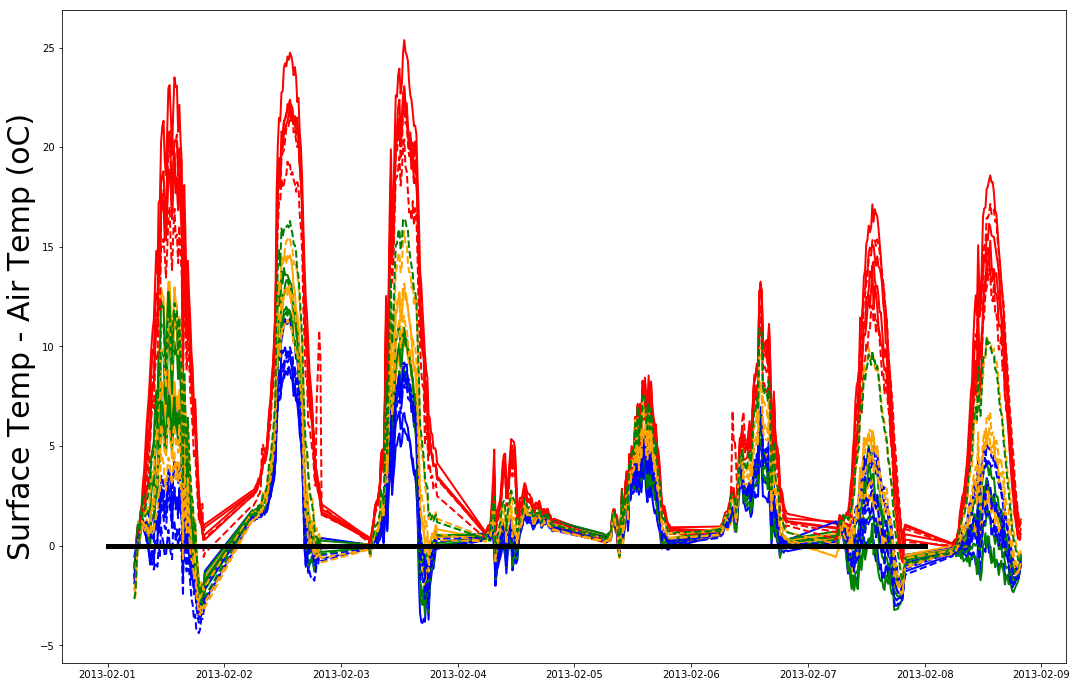

In [11]:
Figure = plt.figure(figsize=(18, 12))
ax = Figure.add_subplot(1,1,1)
GH.AddIndexedPlot(Data.loc[DaylightIndex,'TsTa'].loc[Start:End],ax,GPs,2)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.plot(pd.to_datetime([Start,End]),[0,0], c='k', linewidth=5)

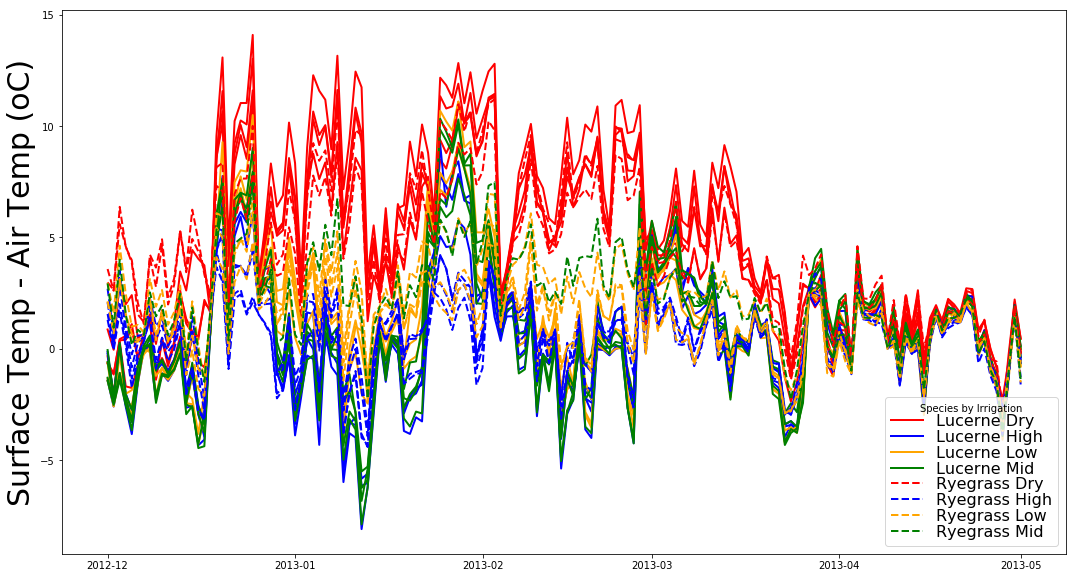

In [19]:
#Agregate data
DayTimeMeanTempDiff = Data.loc[DaylightIndex,'TsTa'].resample('D').mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(DayTimeMeanTempDiff.loc['2012-12-1':'2013-5-1',:],ax,GPs,2)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=4,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Species by Irrigation')

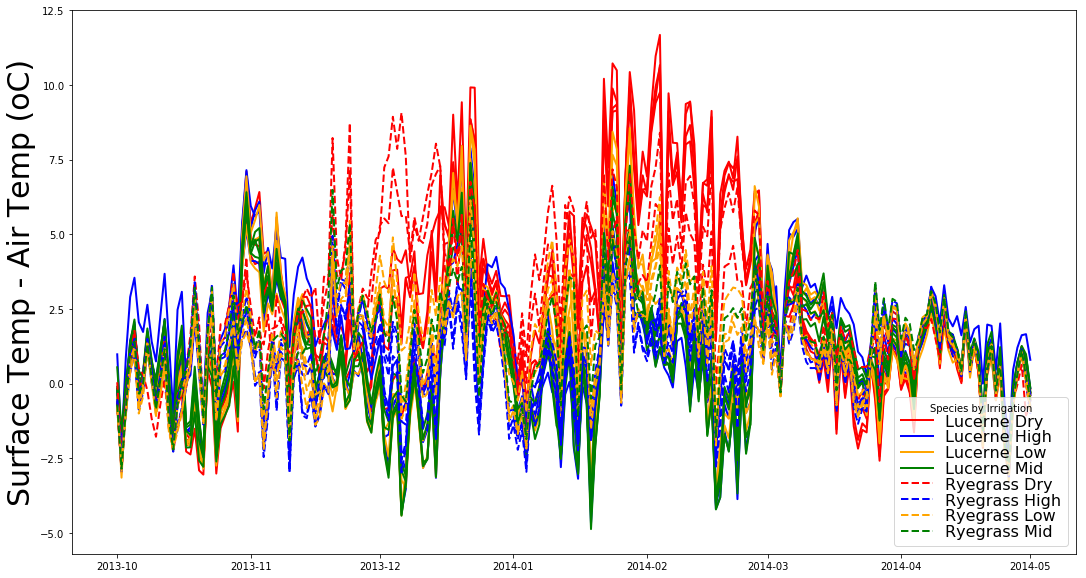

In [20]:
#Agregate data
DayTimeMeanTempDiff = Data.loc[DaylightIndex,'TsTa'].resample('D').mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(DayTimeMeanTempDiff.loc['2013-10-1':'2014-5-1',:],ax,GPs,2)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
ledg = plt.legend(labels, handles,loc=4,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Species by Irrigation')

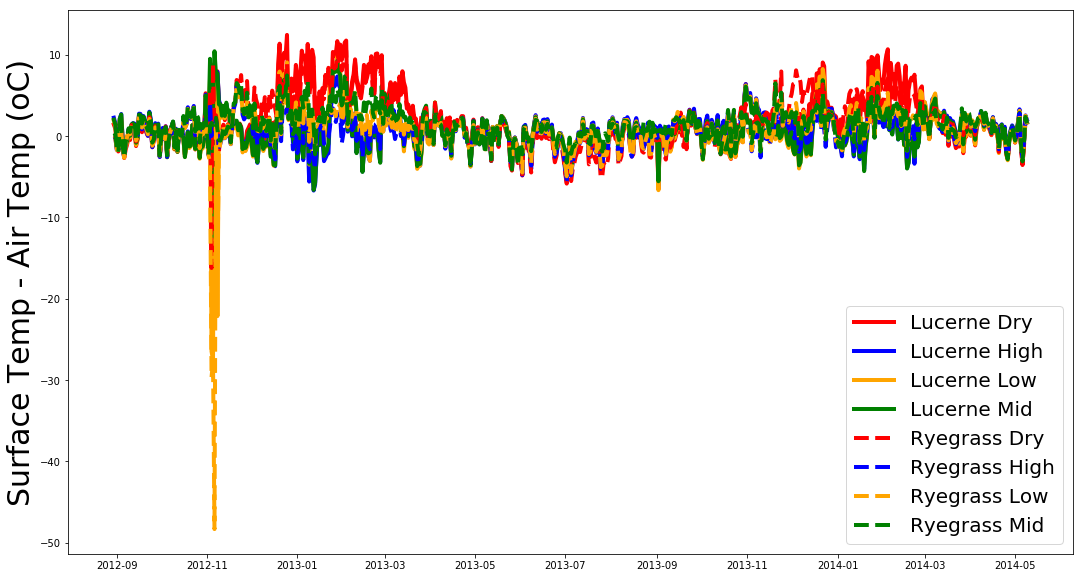

In [21]:
#Agregate data
DayTimeMeanTempDiff = DayTimeMeanTempDiff.groupby(level=['Species','Irrigation'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(DayTimeMeanTempDiff,ax,GPs,4)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.legend(fontsize=20)

In [22]:
DayTimeMeanTempDiff.to_pickle('.\DataFrames\DayTimeMeanSurfaceTemp.pkl')

# Calculate additional variables

## Aerodynamic resistance (Ra)

In [23]:
Data.loc[:,('Ra','Expt', 'Expt','Expt')] = [et.Ra(Data.loc[x,'Windspeed'].values[0],1.2, 0.5) for x in Data.index]

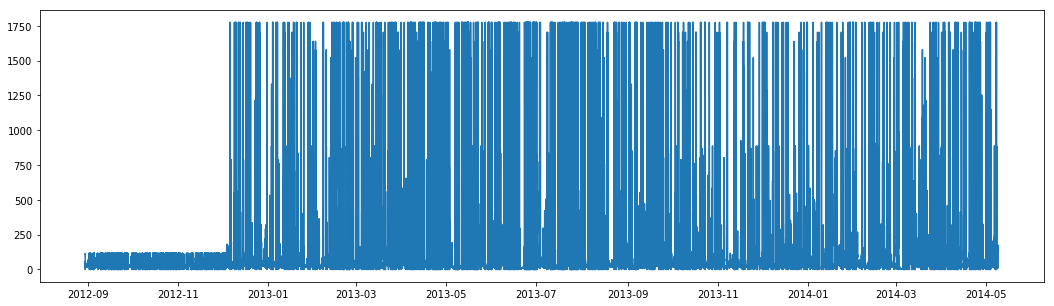

In [24]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.Ra)

## Saturated Vapor pressure (SatVP)

In [25]:
#Function returns SatVP in mbar.  Divide by 10 to convert to kPa
Data.loc[:,('SatVP','Expt', 'Expt','Expt')] = [et.saturated_vapor_pressure(Data.loc[x,'AirTemperature'].values[0])/10 for x in Data.index]

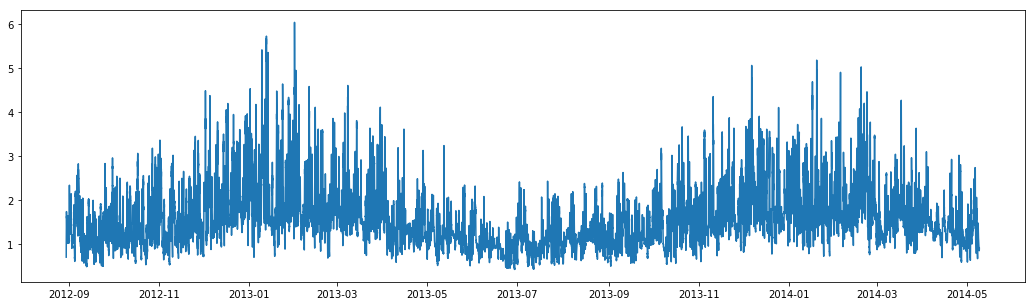

In [26]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.SatVP)

## Vapor pressure (VP)

In [27]:
Data.loc[:,('VP', 'Expt', 'Expt','Expt')] = [Data.loc[x,'SatVP'].values[0] * Data.loc[x,'RelativeHumidity'].values[0]/100 for x in Data.index]

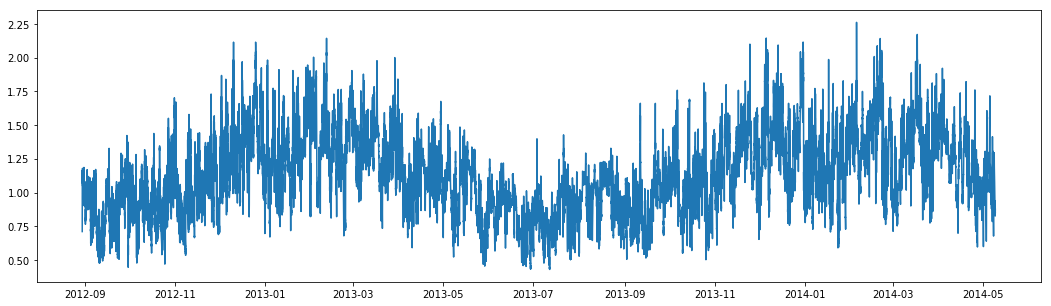

In [28]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.VP)

## Vapor pressure deficit (VPD)

In [29]:
Data.loc[:,('VPD', 'Expt', 'Expt','Expt')] = [Data.loc[x,'SatVP'].values[0] - Data.loc[x,'VP'].values[0] for x in Data.index]

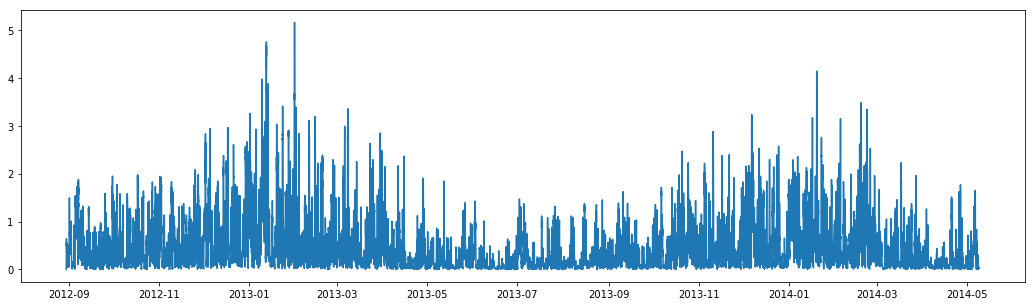

In [30]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.VPD)

Text(0.5,0,'Air Temperature oC')

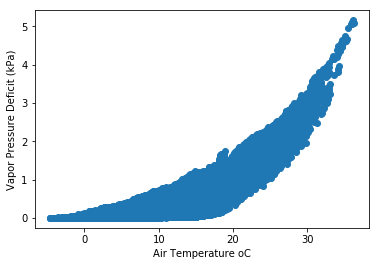

In [31]:
plt.plot (Data.AirTemperature, Data.VPD,'o')
plt.ylabel('Vapor Pressure Deficit (kPa)')
plt.xlabel('Air Temperature oC')

### VPD response to temperature is showing the sort of exponential relationship we would expect

## AirDensity (q)

In [32]:
Data.loc[:,('q','Expt','Expt','Expt')] = [et.AirDensity(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

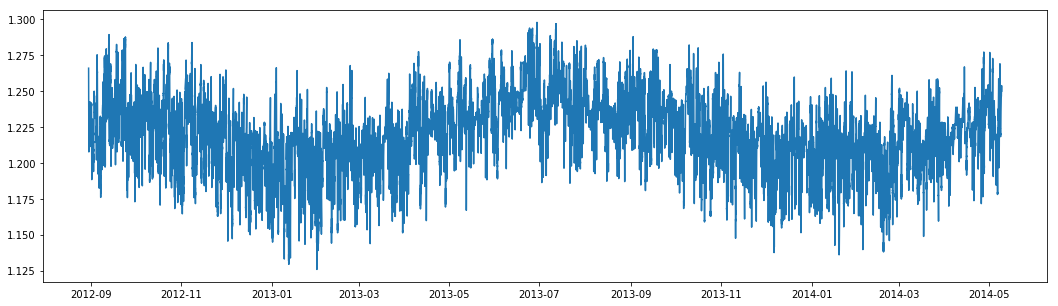

In [33]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.q)

## Phycometric constant (gamma)

In [34]:
Data.loc[:,('gamma','Expt','Expt','Expt')] = [et.gama(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

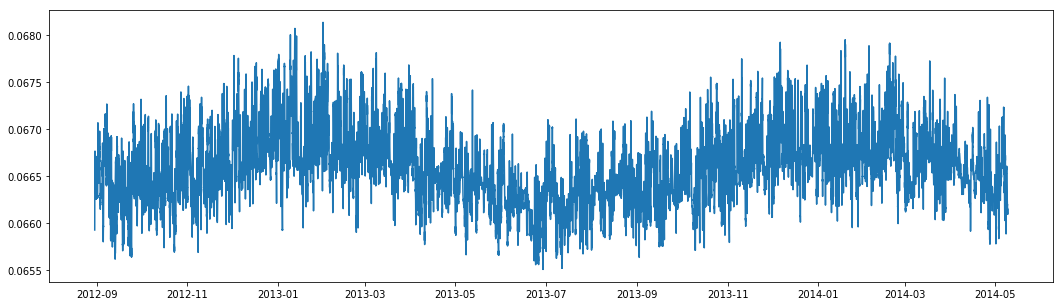

In [35]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.gamma)

## Slope of the satruarted vapour pressure curve (delta)

In [36]:
Data.loc[:,('delta','Expt','Expt','Expt')] = [et.saturated_vapor_pressure_slope(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

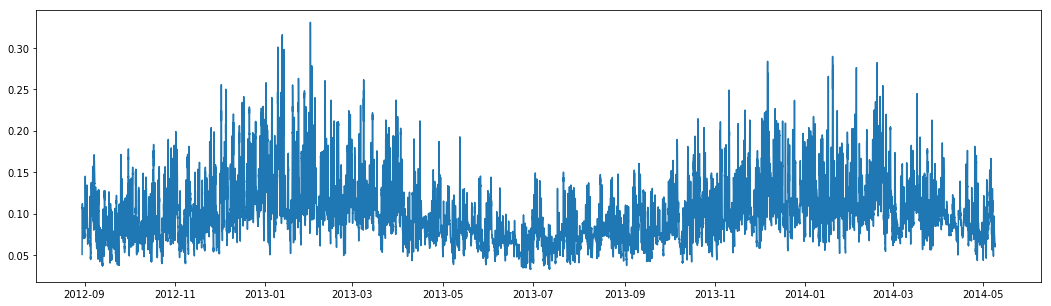

In [37]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.delta)

# latent heat of vaporisation (lamda)

In [38]:
Data.loc[:,('lamda','Expt','Expt','Expt')] = [et.lamda(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

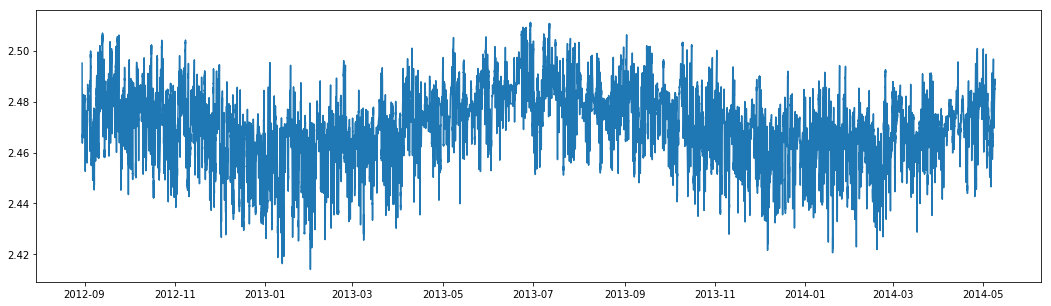

In [39]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.lamda)

## Duration (in hours)

In [40]:
def calcPeriod(End, Start):
    durat = End - Start
    secs = float(durat.seconds)
    _ret = secs/3600
    return _ret
    

In [41]:
Data.loc[:,('Duration','Expt','Expt','Expt')] = [calcPeriod(Data.index[x],Data.index[x-1]) for x in range(Data.index.size)]

(0, 0.4)

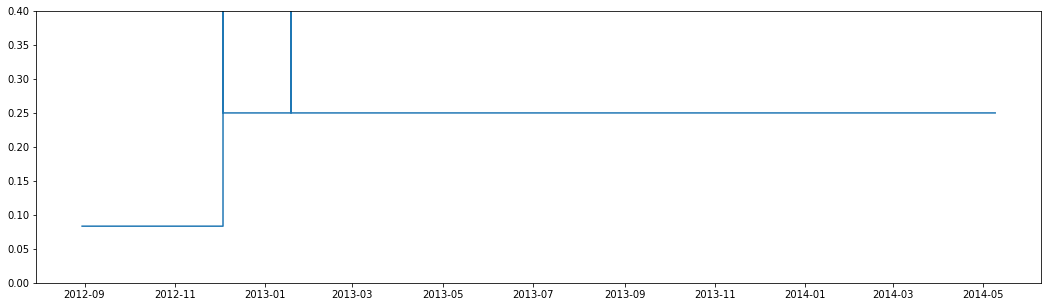

In [43]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.Duration)
plt.ylim(0,0.4)

## Time (in decimal hour scale, 0-24)

In [44]:
def calcTime(DateTimeOfInterest):
    When = DateTimeOfInterest.to_pydatetime()
    zerohour =  datetime.datetime(When.year, When.month, When.day, 0, 0)
    _hour = When - zerohour
    Hour = float(_hour.seconds)/3600
    _ret = 0
    if Hour >1:
        _ret = Hour-1
    else:
        _ret = 23 + Hour
    return _ret

In [45]:
Data.loc[:,('Time','Expt','Expt','Expt')] = [calcTime(Data.index[x]) for x in range(Data.index.size)]

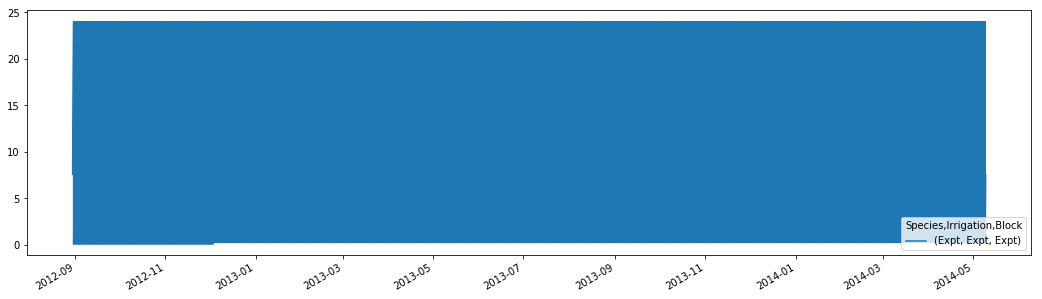

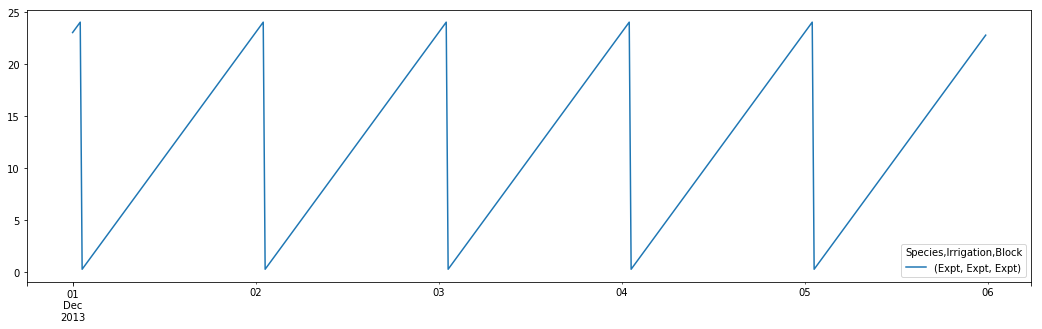

In [48]:
Data.Time.plot(figsize=(18,5))
Data.Time.loc['2013-12-1':'2013-12-5'].plot(figsize=(18,5))

## Day of Year (DOY)

In [49]:
Data.loc[:,('DOY','Expt','Expt','Expt')] = [Data.index[x].dayofyear for x in range(Data.index.size)]

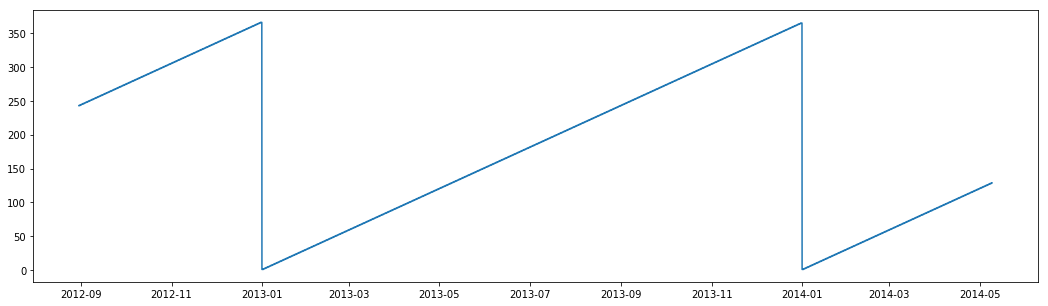

In [50]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.DOY)

## Extrateresteral radiation (Rex)

In [51]:
Data.loc[:,('Rex','Expt','Expt','Expt')] = [et.ExtraterestialRadiation(Lattitude,
                               Data.loc[x,'DOY'].values[0],
                               Data.loc[x,'Duration'].values[0],
                               Data.loc[x,'Time'].values[0],
                               LongitudeTZ,
                               LongitudeML) for x in Data.index]

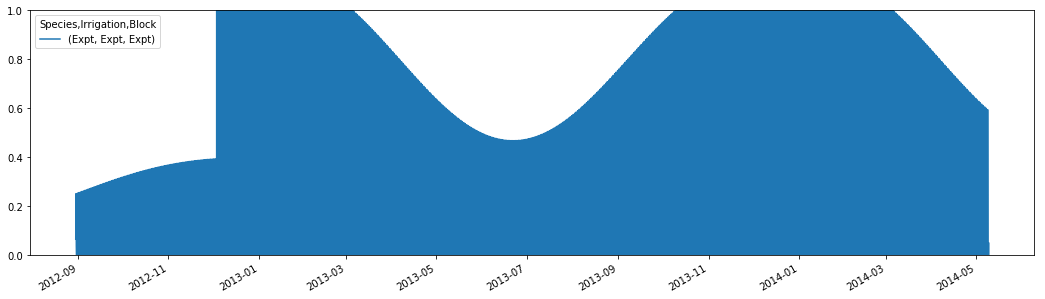

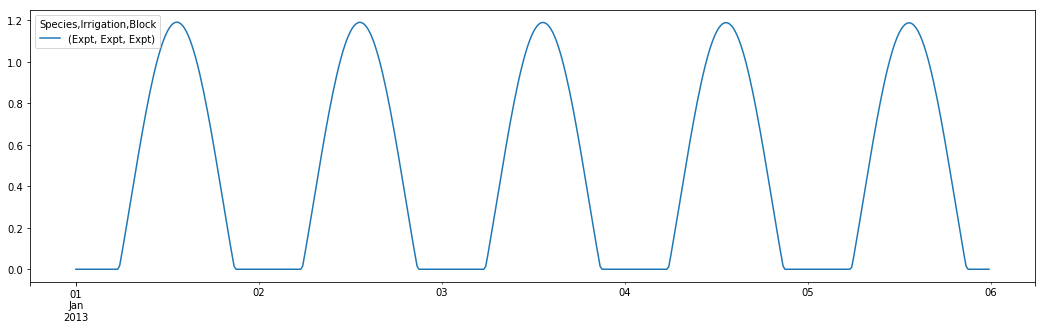

In [56]:
Data.Rex.plot(figsize = (18,5),ylim=(0,1))
Data.Rex.loc['2013-1-1':'2013-1-5'].plot(figsize = (18,5))

## Clear sky radiation (So)

In [57]:
Data.loc[:,('So','Expt','Expt','Expt')] = [et.ClearSkyRadiation(Lattitude,
                               Data.loc[x,'DOY'].values[0],
                               Data.loc[x,'Duration'].values[0],
                               Data.loc[x,'Time'].values[0],
                               LongitudeTZ,
                               LongitudeML) for x in Data.index]

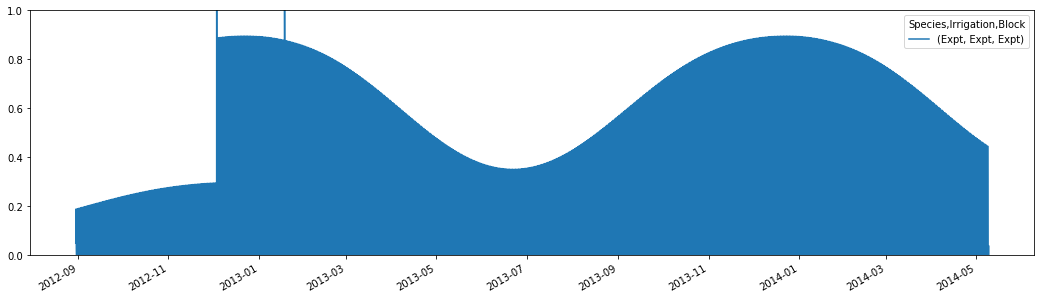

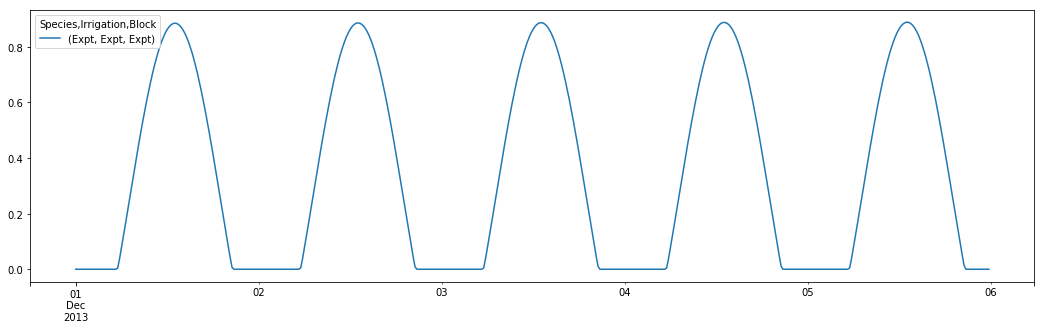

In [58]:
Data.So.plot(figsize = (18,5),ylim=(0,1))
Data.So.loc['2013-12-1':'2013-12-5'].plot(figsize = (18,5))

## Nett Radiation (Rn)

### Calculation Net radiation in MJ/m2

In [59]:
Data.loc[:,('RnMJ','Expt','Expt','Expt')] = [et.NetRadiation(Data.loc[x,'IncomingRadnMJ'].values[0],
                              Data.loc[x,'AirTemperature'].values[0],
                              Data.loc[x,'VP'].values[0],
                              Lattitude,
                              Data.loc[x,'DOY'].values[0],
                              Data.loc[x,'Duration'].values[0],
                              Data.loc[x,'Time'].values[0],
                              LongitudeTZ,
                              LongitudeML,
                              Albedo) for x in Data.index]

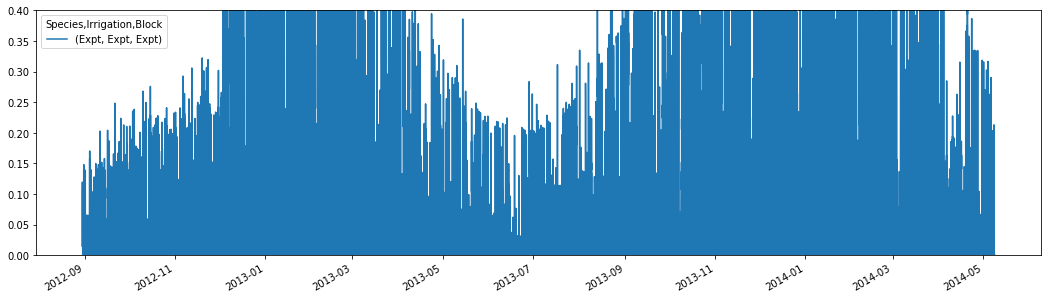

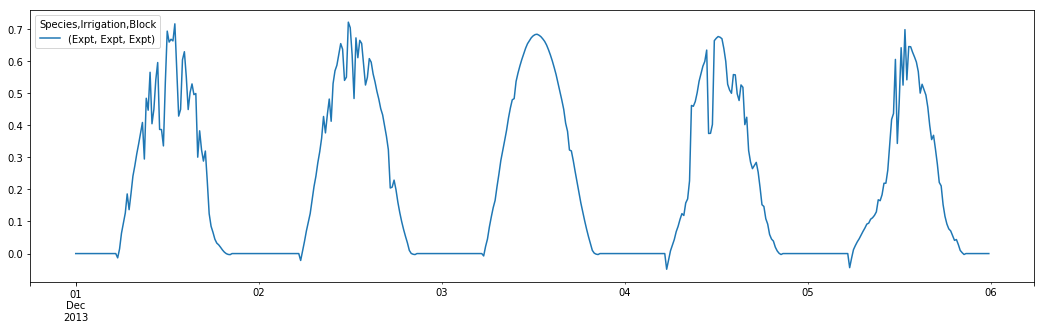

In [60]:
Data.RnMJ.plot(figsize = (18,5),ylim=(0,0.4))
Data.RnMJ.loc['2013-12-1':'2013-12-5'].plot(figsize = (18,5))

Text(0.1,20,'Slope = 0.66')

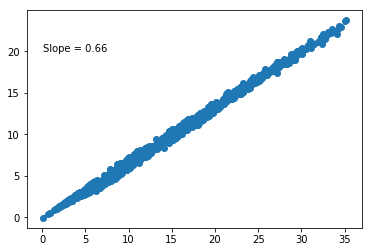

In [61]:
plt.scatter(Data.IncomingRadnMJ.resample('D').sum(),
Data.RnMJ.resample('D').sum())
plt.plot([0,30],[0,20],'-')
plt.text(0.1,20,'Slope = 0.66')

In [62]:
Broadfields = pd.read_pickle('.\DataFrames\BroadFieldsDaily.pkl')

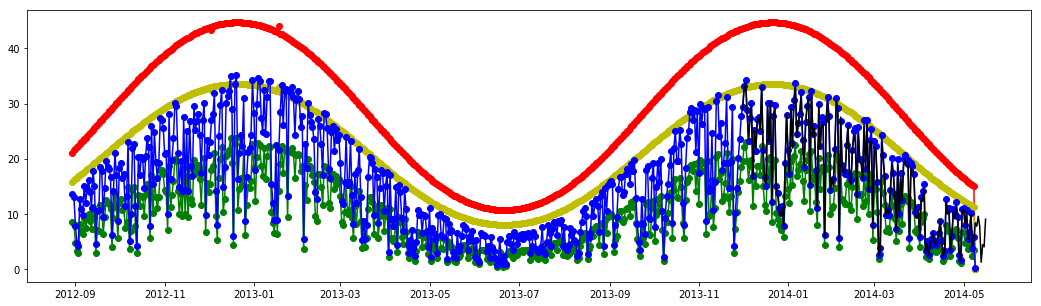

In [63]:
figure = plt.figure(figsize=(18,5))
plt.plot(Data.RnMJ.resample('D').sum(),'-o',color='g')
plt.plot(Data.Rex.resample('D').sum(),'-o',color='r')
plt.plot(Data.So.resample('D').sum(),'-o',color='y')
plt.plot(Data.IncomingRadnMJ.resample('D').sum(),'-o',color='b')
plt.plot(Broadfields.IncomingRadnMJ.loc['2013-12-01':'2014-05-16'], color = 'k')

### Net radiation data all looks good

### Convert to W/m2 by dividing by the period duration in seconds

In [64]:
def calcRnW(RnMJseries,DurationSeries):
    Return = []
    for x in RnMJseries.index:
        if DurationSeries.loc[x][0] == 0:
            Return.append(0)
        else:
            Return.append((RnMJseries.loc[x][0]*1000000)/(DurationSeries.loc[x][0]*3600)) #Multiply by a million to convert to jouls and by 3600 to convert from hours to seconds
    return Return    

In [65]:
Data[('RnW','Expt','Expt','Expt')] = calcRnW(Data.loc[:,'RnMJ'],Data.loc[:,'Duration'])

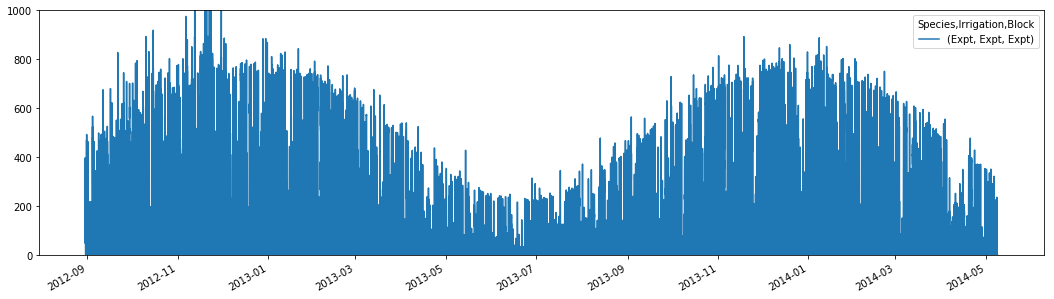

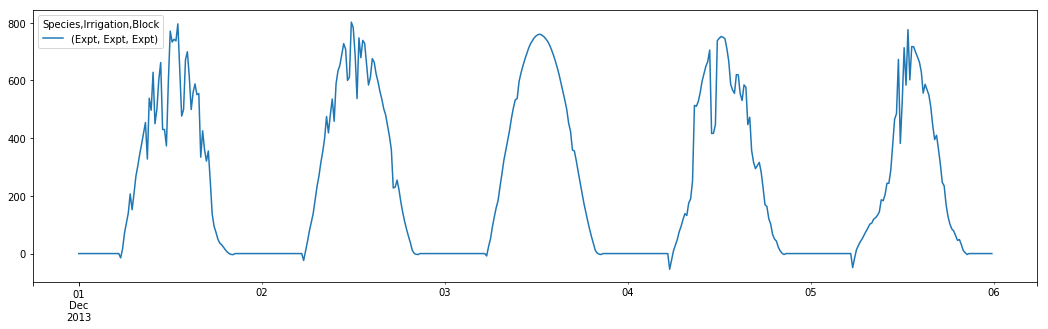

In [66]:
Data.RnW.plot(figsize = (18,5),ylim=(0,1000))
Data.RnW.loc['2013-12-1':'2013-12-5'].plot(figsize = (18,5))

### Instanious net radiation data looks sensible

In [67]:
Data.to_pickle('.\DataFrames\TempAndMet.pkl')

In [68]:
Data.loc[DaylightIndex,'IR_SurfaceTemp'].resample('D').mean().to_pickle('.\DataFrames\DailyTs.pkl')
Data.loc[DaylightIndex,'AirTemperature'].resample('D').mean().to_pickle('.\DataFrames\DailyTa.pkl')
Data.loc[DaylightIndex,'VPD'].resample('D').mean().to_pickle('.\DataFrames\DailyEd.pkl')
Data.loc[DaylightIndex,'IncomingRadnMJ'].resample('D').sum().to_pickle('.\DataFrames\DailyRs.pkl')
Data.loc[DaylightIndex,'VP'].resample('D').mean().to_pickle('.\DataFrames\DailyEo.pkl')